# =========================================================
#     C O G N I V E R S E  -  M L3
# PROJECT: Robô Leitor com GRPO + Unsupervised + RF + 2 Agentes
# =========================================================

In [ ]:
%%capture

!pip install numpy --upgrade --force-reinstall
!pip install --no-cache-dir --force-reinstall pyarrow==14.0.2
!pip install unsloth
!pip install -U sentence-transformers scikit-learn pypdf2 PyCryptodome accelerate einops
!pip install vllm
!pip install --upgrade transformers bitsandbytes
!pip install wandb

In [ ]:
#@title 1. Imports
%%capture

from unsloth import FastLanguageModel
from trl import GRPOTrainer, GRPOConfig
import json
import numpy as np
import requests
import torch
import PyPDF2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, silhouette_score
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForCausalLM
import os
import wandb
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, f1_score

In [ ]:
#@title Requests

# --- Download do PDF ---
PDF_URL = 'https://cdn.shopify.com/s/files/1/2081/8163/files/022-I-FOUND-A-FROG-Free-Childrens-Book-By-Monkey-Pen.pdf?v=1589890638'
PDF_FILENAME = 'Main.pdf'

print(f"A descarregar PDF de: {PDF_URL}...")
r = requests.get(PDF_URL)
with open(PDF_FILENAME, 'wb') as f:
    f.write(r.content)
print("Download concluído!")

def extract_pages(pdf_path):
    pages = []
    if not os.path.exists(pdf_path): return pages
    with open(pdf_path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            text = page.extract_text()
            if text and len(text.strip()) > 10:
                pages.append(text.strip())
    return pages

pages = extract_pages(PDF_FILENAME)
print(f"Total de páginas extraídas: {len(pages)}")


A descarregar PDF de: https://cdn.shopify.com/s/files/1/2081/8163/files/022-I-FOUND-A-FROG-Free-Childrens-Book-By-Monkey-Pen.pdf?v=1589890638...
Download concluído!
Total de páginas extraídas: 19


###Business and Data Understanding


---


**O nosso negócio seria desenvolver um robô que fizesse leitura de livros.**
Ele necessitaria de ter uma base de dados onde nós introduzissemos livros e depois era só pedir uma leitura de x livro e ele lia.


In [ ]:
#@title Data engeneering

# ============================================================
# 1 — DATA ENGINEERING
# Extração → Embeddings → Clustering → RF → Dataset
# ============================================================


PDF_FILENAME = "Main.pdf" # Changed from "livro.pdf" to "Main.pdf"

# -------------------------------
# 1. Extração do PDF
# -------------------------------
def extract_pages(pdf_path):
    pages = []
    if not os.path.exists(pdf_path): return pages
    with open(pdf_path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            text = page.extract_text()
            if text and len(text.strip()) > 10:
                pages.append(text.strip())
    return pages

pages = extract_pages(PDF_FILENAME)
print(f"Total de páginas extraídas: {len(pages)}")


# -------------------------------
# 2. Embeddings
# -------------------------------
embedder = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedder.encode(pages, show_progress_bar=True)


# -------------------------------
# 3. Clustering (descobrir tópicos)
# -------------------------------
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
cluster_ids = kmeans.fit_predict(embeddings)
print("Clustering concluído!")


# -------------------------------
# 4. Avaliação do Clustering
# -------------------------------
sil_score = silhouette_score(embeddings, cluster_ids)
print(f"Silhouette Score: {sil_score:.4f}")


# -------------------------------
# 5. Random Forest como “Juiz”
# -------------------------------
vectorizer = TfidfVectorizer(max_features=1500)
X = vectorizer.fit_transform(pages)
y = cluster_ids

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

print("\n=== Avaliação do RF (Juiz) ===")
print(classification_report(y_test, y_pred := rf.predict(X_test)))
print(confusion_matrix(y_test, y_pred))


# Treinar modelo final
rf_final = RandomForestClassifier(n_estimators=200, random_state=42)
rf_final.fit(X, y)


# -------------------------------
# 6. Criar dataset final
# -------------------------------
dataset = []
for i, text in enumerate(pages):
    dataset.append({
        "id": f"page_{i}",
        "text": text,
        "cluster_id": int(cluster_ids[i]),
        "meta": {"page": i, "book": "Livro_Exemplo"}
    })

with open("dataset_prepared.json", "w", encoding="utf8") as f:
    json.dump(dataset, f, ensure_ascii=False, indent=2)

print("Dataset criado: dataset_prepared.json")

Total de páginas extraídas: 19


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Clustering concluído!
Silhouette Score: 0.1414

=== Avaliação do RF (Juiz) ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      1.00      1.00         1
           2       0.50      0.67      0.57         3

    accuracy                           0.50         6
   macro avg       0.50      0.56      0.52         6
weighted avg       0.42      0.50      0.45         6

[[0 0 2]
 [0 1 0]
 [1 0 2]]
Dataset criado: dataset_prepared.json


In [ ]:
#@title Wandb Starter
from trl import GRPOTrainer, GRPOConfig

# Define config before wandb.init
config = GRPOConfig(
    learning_rate=1e-5,
    num_generations=4,
    max_completion_length=200,
    per_device_train_batch_size=1
)

wandb.init(
    project="grpo-lora-reader",
    name="treino_lora_grpo",
    config={
        "model": "Llama-3.2-3B-Instruct",
        "batch_size": config.per_device_train_batch_size,
        "lr": config.learning_rate,
        "num_generations": config.num_generations,
        "max_completion_length": config.max_completion_length
    }
)

Unsloth: We now expect `per_device_train_batch_size` * `gradient_accumulation_steps` * `world_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 4


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mario-vilares-2024164 (mario-vilares-2024164-istec) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference, openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


In [ ]:
#@title Model Engineering
# ============================================================
# ReaderAgent (Llama + LoRA + GRPO)
# Summarizer
# Q&A
# ============================================================


# ============================================================
# 2 — MODELING
# ReaderAgent (LLaMA) + AnalystAgent + Reward Function
# ============================================================

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from unsloth import FastLanguageModel
from sentence_transformers import util

# -------------------------------
# Perplexidade
# -------------------------------
tok_gpt2 = AutoTokenizer.from_pretrained("gpt2")
model_gpt2 = AutoModelForCausalLM.from_pretrained("gpt2").eval()

def calculate_perplexity(text):
    inputs = tok_gpt2(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        loss = model_gpt2(**inputs, labels=inputs["input_ids"]).loss
    return float(torch.exp(loss).item())


# -------------------------------
# AnalystAgent (Reward)
# -------------------------------
class AnalystAgent:
    def __init__(self, vectorizer, rf, embedder, log_to_wandb=True):
        self.vec = vectorizer
        self.rf = rf
        self.embedder = embedder
        self.history = []
        self.log_to_wandb = log_to_wandb

    def evaluate(self, original, generated):
        # Similaridade
        e1 = self.embedder.encode(original, convert_to_tensor=True)
        e2 = self.embedder.encode(generated, convert_to_tensor=True)
        sim = float(util.pytorch_cos_sim(e1, e2).item())

        # Perplexity Score
        ppl = calculate_perplexity(generated)
        ppl_score = 1 / (1 + 0.1 * np.log(ppl + 1))

        # Tópico (RF)
        orig_topic = self.rf.predict(self.vec.transform([original]))[0]
        gen_topic = self.rf.predict(self.vec.transform([generated]))[0]
        topic_score = 1.0 if orig_topic == gen_topic else 0.0

        # Reward final
        reward = 0.4 * sim + 0.2 * ppl_score + 0.4 * topic_score
        reward = float(max(0, min(1, reward)))  # clamp

        self.history.append({
            "similarity": sim,
            "perplexity": ppl_score,
            "topic_match": topic_score,
            "reward": reward
        })

        return reward


analyst = AnalystAgent(vectorizer, rf_final, embedder)


# -------------------------------
# Prompts + map
# -------------------------------
def build_prompt(ex):
    system = (
        "Tu és um leitor automático.\n"
        "Gera uma leitura natural do texto.\n"
    )
    user = f"CLUSTER={ex['cluster_id']}\nTexto:\n{ex['text']}\n"

    prompt = system + "\n" + user

    return {
        "prompt": prompt,
        "original_text": ex["text"],
        "cluster_id": ex["cluster_id"]
    }

training_data = [build_prompt(ex) for ex in dataset]


# Mapa prompt → original_text
prompt_str_map = {item["prompt"]: item["original_text"] for item in training_data}


# -------------------------------
# Função de Reward GRPO
# -------------------------------
def grpo_reward(prompts, completions, **kwargs):
    rewards = []
    for p, c in zip(prompts, completions):
        prompt_text = p if isinstance(p, str) else str(p)
        original = prompt_str_map.get(prompt_text, "")
        generated = str(c)
        rewards.append(analyst.evaluate(original, generated))
    return rewards


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
print(training_data[0]["prompt"][:500])

Tu és um leitor automático.
Gera uma leitura natural do texto.

CLUSTER=1
Texto:
By T. Albert
Illustrated by  www.maaillustrations.com



In [ ]:
#@title Training
# ============================================================
# 3 — TRAINING (GRPO)
# ============================================================

from trl import GRPOTrainer, GRPOConfig

model, tokenizer = FastLanguageModel.from_pretrained(
    "unsloth/Llama-3.2-3B-Instruct",
    max_seq_length=2048,
    dtype=None,
    load_in_4bit=True,
    device_map="auto"
)

model = FastLanguageModel.get_peft_model(model, r=8)

trainer = GRPOTrainer(
    model=model,
    tokenizer=tokenizer,
    reward_funcs=[grpo_reward],
    args=config,
    train_dataset=training_data
)

print("Iniciando treino...")
trainer.train()
print("Treino concluído!")


model.save_pretrained("modelo_lora_grpo")
tokenizer.save_pretrained("modelo_lora_grpo")

==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.3. vLLM: 0.12.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Iniciando treino...
Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,sampling / sampling_logp_difference / mean,sampling / sampling_logp_difference / max,sampling / importance_sampling_ratio / min,sampling / importance_sampling_ratio / mean,sampling / importance_sampling_ratio / max,kl,rewards / grpo_reward / mean,rewards / grpo_reward / std
1,0.000000,0.634471,0.267962,200.000000,200.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0.000000,0.634471,0.249778
2,0.000000,0.739982,0.049773,189.375000,115.000000,200.000000,0.875000,115.000000,115.000000,115.000000,No Log,No Log,No Log,No Log,No Log,0.000000,0.739982,0.109278
3,-0.000000,0.732206,0.112562,200.000000,200.000000,200.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.000005,0.732206,0.131351
4,-0.000000,0.762463,0.112918,190.500000,124.000000,200.000000,0.875000,124.000000,124.000000,124.000000,No Log,No Log,No Log,No Log,No Log,0.000006,0.762463,0.138870
5,-0.000000,0.486410,0.175390,200.000000,200.000000,200.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.000007,0.486410,0.239231
6,0.000000,0.588975,0.271944,200.000000,200.000000,200.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.000013,0.588975,0.252925
7,0.000000,0.682700,0.132370,200.000000,200.000000,200.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.000009,0.682700,0.189897
8,0.000000,0.569982,0.240637,200.000000,200.000000,200.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.000014,0.569982,0.248376
9,-0.000000,0.475150,0.225396,200.000000,200.000000,200.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.000017,0.475150,0.216135
10,-0.000000,0.674652,0.145860,200.000000,200.000000,200.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.000018,0.674652,0.243815


profiling/Time taken: UnslothGRPOTrainer._calculate_rewards,█▃▂▁▂▃▂▂▂▁▂▂▂▂▂▁▁▂▂▂▂▁▂▂▂▂▁
profiling/Time taken: UnslothGRPOTrainer._prepare_inputs,█▁▁▆▁▁▆▁▆▁▁▆▁▆▁▁▆▆▆▁▁▆▁▆▁▆▆▁▆▁▁▆▁▆▁▁▆▁▆▆
profiling/Time taken: UnslothGRPOTrainer.grpo_reward,█▃▂▁▂▃▂▂▂▁▂▂▂▂▂▁▁▂▂▂▂▁▂▂▂▂▁
profiling/Time taken: UnslothGRPOTrainer.transformers.generate,█▂▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▂▂▂▁▁▁▁▁
train/completion_length,█▃█▄████████▁██▆███████████
train/completions/clipped_ratio,█▁█▁████████▁██▁███████████
train/completions/max_length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/completions/max_terminated_length,▁▆▁▆▁▁▁▁▁▁▁▁▄▁▁█▁▁▁▁▁▁▁▁▁▁▁
train/completions/mean_length,█▃█▄████████▁██▆███████████
train/completions/mean_terminated_length,▁▆▁▆▁▁▁▁▁▁▁▁▄▁▁█▁▁▁▁▁▁▁▁▁▁▁
+14,...


Treino concluído!


('modelo_lora_grpo/tokenizer_config.json',
 'modelo_lora_grpo/special_tokens_map.json',
 'modelo_lora_grpo/chat_template.jinja',
 'modelo_lora_grpo/tokenizer.json')


=== RELATÓRIO DE QUALIDADE ===

       similarity  perplexity  topic_match      reward
count  216.000000  216.000000   216.000000  216.000000
mean     0.496533    0.813150     0.666667    0.627910
std      0.229804    0.065188     0.472500    0.227896
min     -0.024764    0.652666     0.000000    0.152958
25%      0.334639    0.781050     0.000000    0.413036
50%      0.536803    0.810855     1.000000    0.721911
75%      0.678009    0.860013     1.000000    0.812106
max      0.936084    0.927914     1.000000    0.938052


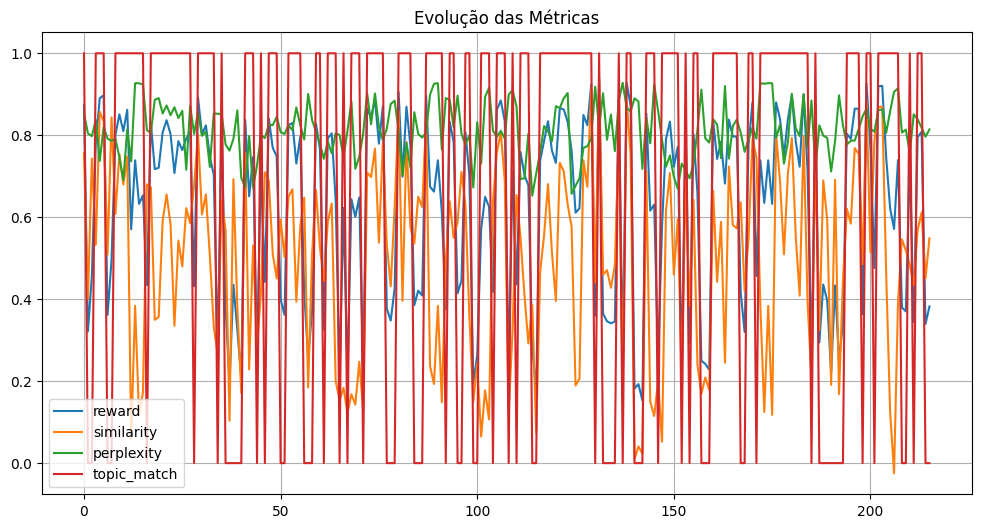


Últimas 10 avaliações:
     similarity  perplexity  topic_match    reward
206   -0.024764    0.905990          1.0  0.571292
207    0.391419    0.914292          1.0  0.739426
208    0.546001    0.806521          0.0  0.379705
209    0.519041    0.813741          0.0  0.370364
210    0.482726    0.756409          1.0  0.744372
211    0.434677    0.851214          0.0  0.344113
212    0.569111    0.838857          1.0  0.795416
213    0.611405    0.818541          1.0  0.808270
214    0.451138    0.796340          0.0  0.339723
215    0.548531    0.814234          0.0  0.382259


In [ ]:
#@title Quality Assurance

# ============================================================
# 4 — QUALITY
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt

print("\n=== RELATÓRIO DE QUALIDADE ===\n")

if len(analyst.history) == 0:
    print("❗ Histórico vazio — reward function não foi chamada.")
else:
    df = pd.DataFrame(analyst.history)

    print(df.describe())

    plt.figure(figsize=(12, 6))
    plt.plot(df["reward"], label="reward")
    plt.plot(df["similarity"], label="similarity")
    plt.plot(df["perplexity"], label="perplexity")
    plt.plot(df["topic_match"], label="topic_match")
    plt.legend()
    plt.title("Evolução das Métricas")
    plt.grid()
    plt.show()

    print("\nÚltimas 10 avaliações:")
    print(df.tail(10))


In [ ]:
#@title DEPLOYMENT

print("A guardar o modelo aprovado para produção...")

# Guardar o modelo final pós-GRPO
model.save_pretrained("modelo_final_aprovado")
tokenizer.save_pretrained("modelo_final_aprovado")

print("Modelo salvo em '/content/modelo_final_aprovado'")

# ------------------------------------------------------------
# 1. Carregar o modelo final (como no inference real)
# ------------------------------------------------------------
print("\nA carregar o modelo para inferência...")

modelo_prod, tokenizer_prod = FastLanguageModel.from_pretrained(
    model_name="modelo_final_aprovado",
    max_seq_length=2048,
    dtype=None,
    load_in_4bit=True,
    device_map="auto"
)

# Ativar LoRA (obrigatório para inferência)
modelo_prod = FastLanguageModel.for_inference(modelo_prod)


# ------------------------------------------------------------
# 2. Função de Inferência (API final do projeto)
# ------------------------------------------------------------
def assistente_leitura(texto_usuario):
    # Formato do prompt igual ao do treino
    messages = [
        {"role": "system", "content": "Tu és um assistente útil que resume e explica textos."},
        {"role": "user", "content": f"Texto: {texto_usuario}"}
    ]

    # Template de chat (Unsloth)
    input_ids = tokenizer_prod.apply_chat_template(
        messages,
        return_tensors="pt",
        add_generation_prompt=True
    ).to(modelo_prod.device)

    # Geração
    with torch.no_grad():
        output = modelo_prod.generate(
            input_ids,
            max_new_tokens=250,
            temperature=0.7,
            do_sample=True,
            repetition_penalty=1.1
        )

    # Decodificação correta
    generated_text = tokenizer_prod.decode(output[0], skip_special_tokens=True)

    # Remover o prompt do início
    clean_text = generated_text.replace(messages[0]["content"], "")
    return clean_text.strip()


# ------------------------------------------------------------
# 3. Demonstração real do sistema
# ------------------------------------------------------------
print("\n--- SIMULAÇÃO DE DEPLOYMENT ---")

texto_teste = (
    "The little frog looked at the sky and wondered why it was so blue. "
    "He jumped happily into the pond."
)

print(f"Input do utilizador:\n{texto_teste}")
print("-" * 60)

resultado = assistente_leitura(texto_teste)
print(f"Resposta do modelo:\n{resultado}")


A guardar o modelo aprovado para produção...
Modelo salvo em '/content/modelo_final_aprovado'

A carregar o modelo para inferência...
==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.3. vLLM: 0.12.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

--- SIMULAÇÃO DE DEPLOYMENT ---
Input do utilizador:
The little frog looked at the sky and wondered why it was so blue. He jumped happily into the pond.
------------------------------------------------------------
Resposta do modelo:
system

Cutting Knowledge Date: December 2023
Today Date: 04 Dec 2025

user

Texto: The little frog looked at the sky and wondered why it was so blue. He jumped

In [ ]:
#@title Monitoring and Maintenance
print("Monitorizar resultados e coletar feedback para manter e melhorar o desempenho do robô assistente.")